# Train a BNN to classify MNIST using SVGD

In [1]:
%load_ext autoreload
# for leonhard
import os
try:
    os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir=" + os.environ["CUDA_HOME"]
except KeyError:
    pass

# Train a Bayesian neural network to classify MNIST using
# Neural SVGD
#
# If using pmap, set the environment variable
# `export XLA_FLAGS="--xla_force_host_platform_device_count=8"`
# before running on CPU (this enables pmap to "see" multiple cores).
import sys
import os
on_cluster = not os.getenv("HOME") == "/home/lauro"
if on_cluster:
    sys.path.append("/cluster/home/dlauro/projects-2020-Neural-SVGD/learning_particle_gradients/")
sys.path.append("../../experiments/")

import argparse
import matplotlib.pyplot as plt
from jax import vmap, random
import jax.numpy as jnp
import numpy as onp
from tqdm import tqdm
import optax
import bnn
import models
import metrics
import mnist
import config as cfg
import utils
from jax import jit, grad, value_and_grad

# Config
key = random.PRNGKey(0)

NUM_SAMPLES = 100
DISABLE_PROGRESS_BAR = False
USE_PMAP = False

BATCH_SIZE = 128
LAMBDA_REG = 1/2
STEP_SIZE = 1e-5
PATIENCE = 15
MAX_TRAIN_STEPS = 50

Loading data...


In [2]:
%autoreload

# init particles and dynamics model

In [9]:
from svgd_bnn import train as train_svgd

final_accs = []

lrs = [1e-6, 5e-6, 8e-6, 1e-5, 2e-5, 5e-5]

key, subkey = random.split(key)

for particle_stepsize in tqdm(lrs):
    final_acc = train_svgd(key=subkey,
                               particle_stepsize=particle_stepsize,
                               n_iter=200,
                               evaluate_every=-1,
                               results_file="/dev/null",
                               optimizer="sgd")
    final_accs.append((final_acc, particle_stepsize))

In [16]:
fa = onp.array(final_accs)
fa

array([[7.50902355e-01, 1.00000000e-06],
       [8.85733247e-01, 5.00000000e-06],
       [9.01073337e-01, 8.00000000e-06],
       [9.14038777e-01, 1.00000000e-05],
       [9.41845477e-01, 2.00000000e-05],
       [9.07176077e-01, 5.00000000e-05]])

In [17]:
fa[:, 1]

array([1.e-06, 5.e-06, 8.e-06, 1.e-05, 2.e-05, 5.e-05])

In [18]:
fa[:, 0]

array([0.75090235, 0.88573325, 0.90107334, 0.91403878, 0.94184548,
       0.90717608])

In [19]:
fa = onp.array(final_accs)
STEP_SIZE = fa[fa[:, 0].argmax(), 1]
STEP_SIZE

In [3]:
STEP_SIZE = 2e-5

In [4]:
def init_particles_fn(subkey):
    init_particles = vmap(bnn.init_flat_params)(random.split(subkey, NUM_SAMPLES))
    return init_particles


key, subkey = random.split(key)
init_particles = init_particles_fn(subkey)
opt = optax.sgd(STEP_SIZE)
# opt = optax.adam(ADAM_STEP_SIZE)

key, subkey1, subkey2 = random.split(key, 3)
svgd_grad = models.KernelGradient(get_target_logp=bnn.get_minibatch_logp,
                                  scaled=False)

particles = models.Particles(key=subkey2,
                             gradient=svgd_grad.gradient,
                             init_samples=init_particles,
                             custom_optimizer=opt)

# minibatch_vdlogp = jit(vmap(value_and_grad(bnn.minibatch_logp), (0, None)))

@jit
def compute_eval(step_counter, ps, loglikelihood):
    stepdata = {
        "accuracy": (step_counter, bnn.compute_acc_from_flat(ps)),
        "particle_mean": (step_counter, ps.mean()),
        "loglikelihood": loglikelihood.mean(),
    }
    return stepdata


SGLD_STEPSIZE = 5e-8
print('SGLD noise   :', jnp.sqrt(2*SGLD_STEPSIZE))
print('SVGD stepsize:', STEP_SIZE)
sgld = utils.sgld(SGLD_STEPSIZE)
sgld_state = sgld.init(init_particles)


@jit
def sgld_step(particles, dlogp, sgld_state):
    """Update param_set elements in parallel using Langevin dynamics."""
    g, sgld_state = sgld.update(-dlogp, sgld_state, particles)
    particles = optax.apply_updates(particles, g)
    aux = {
        "global_grad_norm": optax.global_norm(g),
    }
    return particles, sgld_state, aux

step_counter = 0

SGLD noise   : 0.00031622776
SVGD stepsize: 2e-05


In [5]:
# num_steps = EPOCHS * data_size // BATCH_SIZE // 5
num_steps = 422*2
sgld_aux = {}
for _ in tqdm(range(num_steps)):
    step_counter += 1
    train_batch = next(mnist.training_batches)
    particles.step(train_batch)

    if step_counter % 10 == 0:
        metrics.append_to_log(particles.rundata,
                              compute_eval(step_counter,
                                           particles.particles,
                                           jnp.array(1)))
        
# neural_grad.done()
# particles.done()

100%|██████████| 844/844 [00:50<00:00, 16.64it/s]


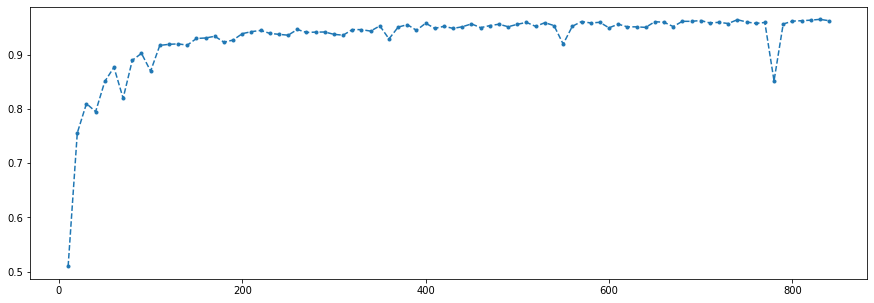

In [6]:
fig, ax = plt.subplots(figsize=[15, 5])
ax.plot(*zip(*particles.rundata['accuracy']), "--.", label="accuracy")

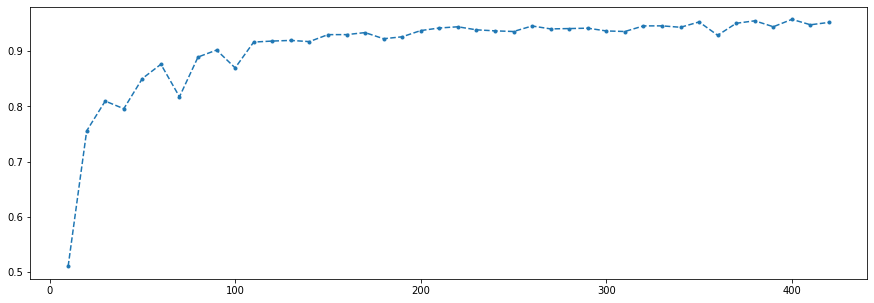

In [8]:
fig, ax = plt.subplots(figsize=[15, 5])
ax.plot(*zip(*particles.rundata['accuracy']), "--.", label="accuracy")

In [9]:
particles.rundata['accuracy'][-1]

(Buffer(420, dtype=int32), Buffer(0.9523651, dtype=float32))

In [10]:
import json_tricks as json

savedict = {
    "accuracy": onp.array(particles.rundata['accuracy']).tolist(),
#     "loglikelihood": onp.array(particles.rundata['loglikelihood']).tolist(),
}

folder = "svgd/"
# onp.save(folder + "params.npy", particles.particles)
# with open(folder + "rundata.json", "w") as f:
#     json.dump(savedict, f, indent=4)

In [10]:
# onp.save("svgd_trained", particles.particles)

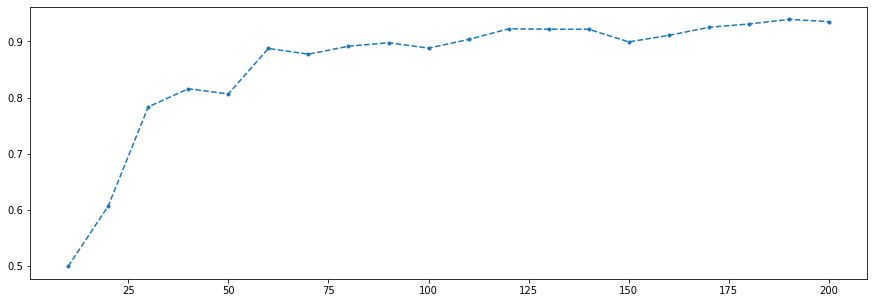

In [22]:
fig, ax = plt.subplots(figsize=[15, 5])
ax.plot(*zip(*particles.rundata['accuracy']), "--.", label="accuracy")

In [23]:
particles.rundata['accuracy'][-5:]

[(Buffer(160, dtype=int32), Buffer(0.9105005, dtype=float32)),
 (Buffer(170, dtype=int32), Buffer(0.924867, dtype=float32)),
 (Buffer(180, dtype=int32), Buffer(0.93077976, dtype=float32)),
 (Buffer(190, dtype=int32), Buffer(0.9390197, dtype=float32)),
 (Buffer(200, dtype=int32), Buffer(0.9348641, dtype=float32))]

In [24]:
particles.rundata.keys()

dict_keys(['mean', 'particles', 'std', 'step', 'bandwidth', 'global_grad_norm', 'global_grad_norm_post_update', 'logp', 'accuracy', 'loglikelihood', 'particle_mean'])

In [30]:
with open('svgd.csv', "w") as f:
    f.write('step,accuracy')

In [31]:
with open('svgd.csv', "a") as f:
    for (i, a) in particles.rundata['accuracy']:
        f.write(f'{i.tolist()},{a.tolist()}\n')

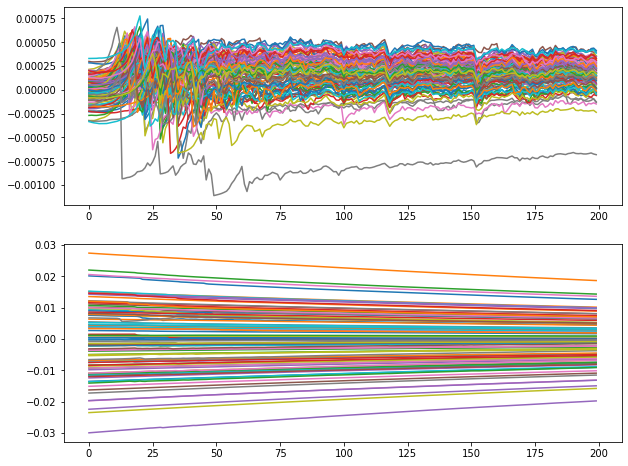

In [25]:
trajectories = onp.array(particles.rundata['particles'])
trajectories.shape

# visualize trajectory avg across dimensions (distinguish particles)
fig, axs = plt.subplots(2, 1, figsize=[10, 8])

ax = axs[0]
ax.plot(trajectories.mean(axis=2));  # avg across dims

ax = axs[1]
ax.plot(trajectories[:, :, 1]);  # watch single param (aka single dimension)